In [1]:
#@title Setup (may take a few minutes)

from pathlib import Path
import torch.utils.checkpoint
import itertools
from accelerate import Accelerator
from datasets import prompt_dataset
from diffusers.pipelines import AutoPipelineForText2Image
import utils
import time
import numpy as np
import cv2
import torchvision.transforms.functional as TF
import os

import shutil


# Hyperparameters

In [2]:

counting_model_name: str = 'clip-count' #@param ['clip','clip-count'] {type:"string"}

clazz: str = "oranges" #@param {type:"string"}
amount: int = 5 #@param {type:"number"}

_lambda: float = 5  #@param {type:"number"}
scale: float = 60 # 80  #@param {type:"number"}
is_dynamic_scale_factor: bool = True #@param {type:"boolean"}
yolo_threshold: float = 0.5 #@param {type:"number"}

# Affect training time
early_stopping: int = 15 #@param {type:"integer"}
num_train_epochs: int = 50 #@param {type:"integer"}

# affect variability of the training images
# i.e., also sets batch size with accumulation
epoch_size: int = 1 #@param {type:"integer"}
number_of_prompts: int = 1 #@param {type:"integer"}
batch_size: int = 1 #@param {type:"integer"}
gradient_accumulation_steps: int = 1 #@param {type:"integer"}

# Skip if there exists a token checkpoint
skip_exists: bool = False #@param {type:"boolean"}

# Train and Optimization
lr: float = 0.05 #@param {type:"number"}
betas1: tuple = 0.9 #@param {type:"number"}
betas2: tuple = 0.999 #@param {type:"number"}
betas = (betas1, betas2)


weight_decay: float = 1e-2 #@param {type:"number"}
eps: float = 1e-08 #@param {type:"number"}
max_grad_norm: str = "1" #@param {type:"string"}
seed: int = 35 #@param {type:"integer"}

# Generative model
guidance_scale: int = 7 #@param {type:"integer"}
height: int = 512 #@param {type:"integer"}
width: int = 512 #@param {type:"integer"}
num_of_SD_inference_steps: int = 35 #@param {type:"integer"}
num_of_SD_backpropagation_steps: int = 1 #@param {type:"integer"}

# Discriminative tokens
placeholder_token: str = "newcls" #@param {type:"string"}
initializer_token: str = "some" #@param {type:"string"}

# Path to save all outputs to
output_path: str = "results" #@param {type:"string"}
save_as_full_pipeline: bool = True #@param {type:"boolean"}

# Cuda related
device: str = "cuda" #@param {type:"string"}
mixed_precision: str = "no" #@param ["fp16", "fp32"] {type:"string"}
gradient_checkpointing: bool = True #@param {type:"boolean"}

# evaluate
test_size: int = 3 #@param {type:"integer"}

In [3]:
from collections import namedtuple
# Define the configuration names
config_names = [
    "counting_model_name",
    "early_stopping",
    "num_train_epochs",
    "epoch_size",
    "number_of_prompts",
    "batch_size",
    "gradient_accumulation_steps",
    "skip_exists",
    "betas",
    "lr",
    "eps",
    "weight_decay",
    "seed",
    "max_grad_norm",
    "guidance_scale",
    "height",
    "width",
    "num_of_SD_inference_steps",
    "num_of_SD_backpropagation_steps",
    "placeholder_token",
    "initializer_token",
    "output_path",
    "save_as_full_pipeline",
    "device",
    "mixed_precision",
    "gradient_checkpointing",
    "test_size",
    "scale",
    "is_dynamic_scale_factor",
    "yolo_threshold",
    "clazz",
    "amount"
]

# Use globals() to extract values from matching variable names
config_values = [globals()[name] for name in config_names]

# Create the named tuple
Config = namedtuple("Config", config_names)
config = Config(*config_values)
config

Config(counting_model_name='clip-count', early_stopping=15, num_train_epochs=50, epoch_size=1, number_of_prompts=1, batch_size=1, gradient_accumulation_steps=1, skip_exists=False, betas=(0.9, 0.999), lr=0.05, eps=1e-08, weight_decay=0.01, seed=35, max_grad_norm='1', guidance_scale=7, height=512, width=512, num_of_SD_inference_steps=35, num_of_SD_backpropagation_steps=1, placeholder_token='newcls', initializer_token='some', output_path='results', save_as_full_pipeline=True, device='cuda', mixed_precision='no', gradient_checkpointing=True, test_size=3, scale=60, is_dynamic_scale_factor=True, clazz='oranges', amount=5)


# Train

In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Start experiment 1_0.05_35_1_15
Start training class token for 5 oranges


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/1 [00:00<?, ?it/s]

SDXL took 0.4136967062950134 minutes
YOLO found: 9 objects, predicted scale factor is: 119.6875
On epoch 0 
['A photo of newcls 5 oranges'] 
output.item()=9.0 
Loss: 7.39453125 
Clip-Count loss: 4.000278949737549 
Clip loss: 3.394252300262451


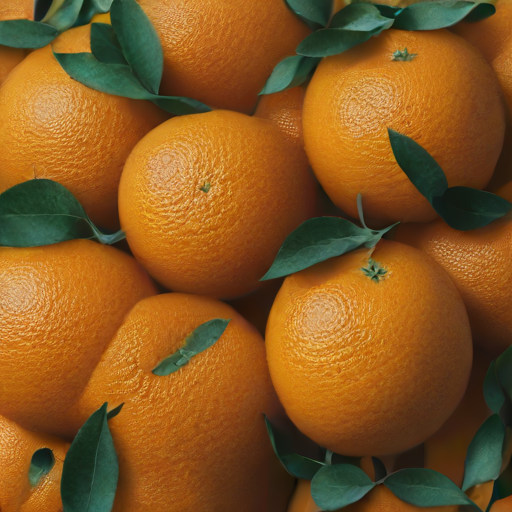

NameError: name 'yolo_image' is not defined

In [5]:
from transformers import YolosForObjectDetection, YolosImageProcessor
from PIL import Image
from torchvision.transforms import transforms

# Predict Scale Factor help functions
def load_image(img):
    if isinstance(img, str) and os.path.isfile(img):
        # img is a file path, open with PIL.Image.open()
        return Image.open(img)
    elif isinstance(img, torch.Tensor):
        # img is a tensor, convert to PIL image
        transform_to_pil = transforms.ToPILImage()
        return transform_to_pil(img.squeeze())
    else:
        raise ValueError("The provided input is neither a valid file path nor a tensor.")

def run_yolo(model, image_processor, image, clazz, threshold=0.4):
    count = 0
    # image = Image.open(image)
    image = load_image(image)

    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    
    # print results
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold, target_sizes=target_sizes)[0]
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if model.config.id2label[label.item()] == clazz:
            count += 1

    return count

def extract_clip_count_scale_factor(image, density_map, yolo, yolo_image_processor):
    with torch.no_grad():
        num_of_objects = run_yolo(yolo, yolo_image_processor, image, config.clazz[:-1], threshold=0.7)
        predicted_scale_factor = torch.sum(density_map / num_of_objects).item()
        print(f"YOLO found: {num_of_objects} objects, predicted scale factor is: {predicted_scale_factor}")
        return predicted_scale_factor

os.environ['TORCH_USE_CUDA_DSA'] = "1"
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(config.seed)
torch.cuda.manual_seed(config.seed)

# Counting model
counting_model = utils.prepare_counting_model(config)
clip, processor = utils.prepare_clip(config)
if config.is_dynamic_scale_factor:
    yolo = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
    yolo_image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")
 
exp_identifier = (
    f'{config.epoch_size}_{config.lr}_'
    f"{config.seed}_{config.number_of_prompts}_{config.early_stopping}"
)

#### Train ####
print(f"Start experiment {exp_identifier}")

class_name = f"{config.amount} {config.clazz}"
print(f"Start training class token for {class_name}")
img_dir_path = f"img/{class_name}/train"
if Path(img_dir_path).exists():
    shutil.rmtree(img_dir_path)
Path(img_dir_path).mkdir(parents=True, exist_ok=True)

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float32
).to(device)

unet, vae, text_encoder, scheduler, tokenizer = pipeline.unet, pipeline.vae, pipeline.text_encoder, pipeline.scheduler, pipeline.tokenizer

#  Extend tokenizer and add a discriminative token ###
class_infer = int(class_name.split()[0])
prompt_suffix = " ".join(class_name.lower().split("_"))

## Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(config.placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {config.placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

## Get token ids for our placeholder and initializer token.
# This code block will complain if initializer string is not a single token
## Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(config.initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(config.placeholder_token)

# we resize the token embeddings here to account for placeholder_token
text_encoder.resize_token_embeddings(len(tokenizer))

#  Initialise the newly added placeholder token
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

# Define dataloades

def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids
    texts = [example["instance_prompt"] for example in examples]
    batch = {
        "texts": texts,
        "input_ids": input_ids,
    }

    return batch

train_dataset = prompt_dataset.PromptDataset(
    prompt_suffix=prompt_suffix,
    tokenizer=tokenizer,
    placeholder_token=config.placeholder_token,
    number_of_prompts=config.number_of_prompts,
    epoch_size=config.epoch_size,
)

train_batch_size = config.batch_size
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
)

# Define optimization

## Freeze vae and unet
utils.freeze_params(vae.parameters())
utils.freeze_params(unet.parameters())

## Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
utils.freeze_params(params_to_freeze)

optimizer_class = torch.optim.AdamW
optimizer = optimizer_class(
    text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
    eps=config.eps,
)
criterion = torch.nn.L1Loss().cuda()

accelerator = Accelerator(
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    mixed_precision=config.mixed_precision,
)

if config.gradient_checkpointing:
    text_encoder.gradient_checkpointing_enable()
    unet.enable_gradient_checkpointing()

text_encoder, optimizer, train_dataloader = accelerator.prepare(
    text_encoder, optimizer, train_dataloader
)

weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move vae and unet to device
vae.to(accelerator.device, dtype=weight_dtype)
unet.to(accelerator.device, dtype=weight_dtype)

counting_model = counting_model.to(accelerator.device)
text_encoder = text_encoder.to(accelerator.device)

# Keep vae in eval mode as we don't train it
vae.eval()
# Keep unet in train mode to enable gradient checkpointing
unet.train()

global_step = 0
total_loss = 0
min_loss = 99999

# Define token output dir
token_dir_path = f"token/{class_name}"
token_path = f"{token_dir_path}/{exp_identifier}_{class_name}"
Path(token_path).mkdir(parents=True, exist_ok=True)

#### Training loop ####
train_start = time.time()
for epoch in range(config.num_train_epochs):
    print(f"Epoch {epoch}")
    generator = torch.Generator(
        device=config.device
    )  # Seed generator to create the inital latent noise
    generator.manual_seed(config.seed)
    for step, batch in enumerate(train_dataloader):
        step_start = time.time()
        # setting the generator here means we update the same images
        classification_loss = None
        with accelerator.accumulate(text_encoder):

            generator.manual_seed(config.seed)
            
            t1 = time.time()
            # generate image            
            image = pipeline(prompt=batch['texts'][0],
                num_inference_steps=1,
                output_type="pt",
                height=config.height,
                width=config.width,
                generator=generator,
                guidance_scale=0.0
            ).images[0] 
            print(f"SDXL took {(time.time()-t1)/60} minutes")
            
            image = image.unsqueeze(0)
            image_out = image
            image = utils.transform_img_tensor(image, config).to(device)
            
            prompt = [class_name.split()[-1]]
            
            with torch.cuda.amp.autocast():
                orig_output = counting_model(image, prompt)
            
            scale_factor = extract_clip_count_scale_factor(image_out.detach(), orig_output[0].detach(), yolo, yolo_image_processor) if config.is_dynamic_scale_factor else config.scale
            output = torch.sum(orig_output[0] / scale_factor)

            if classification_loss is None:
                classification_loss = criterion(
                    output, torch.HalfTensor([class_infer]).cuda()
                )/torch.HalfTensor([1]).cuda() # TODO removed power 2
            else:
                classification_loss += criterion(
                    output, torch.HalfTensor([class_infer]).cuda()
                )/torch.HalfTensor([1]).cuda() # TODO removed power 2
                            
            text_inputs = processor(text=prompt, return_tensors="pt", padding=True).to(device)
            inputs = {**text_inputs, "pixel_values": image}
            clip_output = (clip(**inputs)[0][0]/100).cuda()
            clip_output = _lambda * (1-clip_output)

            classification_loss += clip_output

            total_loss += classification_loss.detach().item()

            # log
            txt = f"On epoch {epoch} \n"
            with torch.no_grad():
                txt += f"{batch['texts']} \n"
                txt += f"{output.item()=} \n"
                txt += f"Loss: {classification_loss.detach().item()} \n"
                txt += f"Clip-Count loss: {classification_loss.detach().item()-clip_output.detach().item()} \n"
                txt += f"Clip loss: {clip_output.detach().item()}"
                with open("run_log.txt", "a") as f:
                    print(txt, file=f)
                print(txt)
                display(utils.numpy_to_pil(
                    image_out.detach().permute(0, 2, 3, 1).cpu().numpy()
                )[0])
                                
                # counting prediction heatmap
                pred_density = orig_output[0].detach().cpu().numpy()
                pred_density = pred_density/pred_density.max()
                pred_density_write = 1. - pred_density
                pred_density_write = cv2.applyColorMap(np.uint8(255*pred_density_write), cv2.COLORMAP_JET)
                pred_density_write = pred_density_write/255.
                img = TF.resize(image.detach(), (384)).squeeze(0).permute(1, 2, 0).cpu().numpy()
                heatmap_pred = 0.33 * img + 0.67 * pred_density_write
                heatmap_pred = heatmap_pred/heatmap_pred.max()
                display(utils.numpy_to_pil(
                    heatmap_pred
                )[0])
                
            torch.nn.utils.clip_grad_norm_(
                text_encoder.get_input_embeddings().parameters(),
                config.max_grad_norm,
            )

            start_back = time.time()
            
            accelerator.backward(classification_loss)
            
            # Zero out the gradients for all token embeddings except the newly added
            # embeddings for the concept, as we only want to optimize the concept embeddings
            if accelerator.num_processes > 1:
                grads = (
                    text_encoder.module.get_input_embeddings().weight.grad
                )
            else:
                grads = text_encoder.get_input_embeddings().weight.grad

            # Get the index for tokens that we want to zero the grads for
            index_grads_to_zero = (
                torch.arange(len(tokenizer)) != placeholder_token_id
            )
            grads.data[index_grads_to_zero, :] = grads.data[
                index_grads_to_zero, :
            ].fill_(0)

            # Checks if the accelerator has performed an optimization step behind the scenes\n",
            if step == config.epoch_size - 1:
                if total_loss > 2 * min_loss:
                    print("!!!!training collapse, try different hp!!!!")
                    # epoch = config.num_train_epochs
                    # break
                print("update")
                if total_loss < min_loss:
                    min_loss = total_loss
                    current_early_stopping = config.early_stopping
                    # Create the pipeline using the trained modules and save it.
                    accelerator.wait_for_everyone()
                    if accelerator.is_main_process:
                        token_embeds = text_encoder.get_input_embeddings().weight.data
                        torch.save(token_embeds[placeholder_token_id], f"{token_path}/token_embeds.pt")
                        print(f"Saved the new discriminative class token pipeline of {class_name} to pipeline_{token_path}")
                else:
                    current_early_stopping -= 1
                print(
                    f"{current_early_stopping} steps to stop, current best {min_loss}"
                )

                total_loss = 0
                global_step += 1

            optimizer.step()
            optimizer.zero_grad()
    
    print(f"End step duration: {(time.time()-step_start)/60} minutes")
    if current_early_stopping < 0:
        break
        
print(f"End train time: {(time.time()-train_start)/60} minutes")


# Eval

In [ ]:
print("Evaluation - print image without discriminatory tokens, then one with.")
# Stable model
# token_dir_path = f"token/{class_name}"
# Path(token_dir_path).mkdir(parents=True, exist_ok=True)
# text_path = f"pipeline_{token_dir_path}/{exp_identifier}_{class_name}"
# loaded_embeds = torch.load(f'{token_path}/token_embeds.pt')
# 
# pipeline = AutoPipelineForText2Image.from_pretrained(
#     pretrained_model_or_path="stabilityai/sdxl-turbo",
#     torch_dtype=torch.float32
# ).to(device)
# 
# tokenizer, text_encoder = pipeline.tokenizer, pipeline.text_encoder
# tokenizer.add_tokens(config.placeholder_token)
# text_encoder.resize_token_embeddings(len(tokenizer))
# token_embeds = text_encoder.get_input_embeddings().weight.data
# token_embeds[placeholder_token_id] = loaded_embeds

generator = torch.Generator(device=config.device)  # Seed generator to create the initial latent noise
generator.manual_seed(config.seed)

for descriptive_token in ["some", config.placeholder_token]:
  generator.manual_seed(config.seed)
  prompt = f"A photo of {descriptive_token} {class_name}"
  print(f"Evaluation for the prompt: {prompt}")

  image = pipeline(prompt=prompt,
        num_inference_steps=1,
        output_type="pt",
        height=config.height,
        width=config.width,
        generator=generator,
        guidance_scale=0.0
  ).images[0] 
  
  display(utils.numpy_to_pil(image.permute(1, 2, 0).cpu().detach().numpy())[0])